In [1]:
import os
import sys
module_path = os.path.abspath(os.path.join('..'))
if module_path not in sys.path:
    sys.path.append(module_path)

In [2]:
import skmob
import osmnx as ox  # version '0.16.0' or greater
import mobair as mb

### Loading input files...

- `modelli_auto` contains the vehicles' information from which the `fuel_type` will be extracted;
- `emission_functions` contains the values for the emission functions
- `max_interval` is the maximum time interval (in seconds) that one wants between each pair of points in the trajectories;
- `region` is just the name of the region for which the road network is needed;
- `pollutant_to_plot` is one of `{'CO_2', 'NO_x', 'PM', 'VOC'}`

In [3]:
###### Parameters here:
path_to_table_with_info_on_vehicles = './data/modelli_auto.tar.xz'
path_to_table_with_emission_functions = './data/emission_functions.csv'
max_interval = 120
region = 'Rome'
pollutant_to_plot = 'CO_2' # one of: CO_2, NO_x, PM, VOC
######

#### Loading a little tdf from ./data

- `some_trajectories_in_Rome.json` is a `TrajDataFrame` with a little sample of trajectories of some vehicles moving in the center of Rome;

In [4]:
path_to_input_file = './data/some_trajectories_in_Rome.json'
tdf = skmob.read(path_to_input_file)

print("Num of selected trajectories ('tid'):", len(set(tdf['tid'])))
set_of_uid_in_input = set(tdf['uid'])
num_of_uid_in_input = len(set_of_uid_in_input)
print("Num of vehicles ('uid'):", num_of_uid_in_input)
tdf.drop(['tile_ID'], axis=1).head()  # (dropping column 'tileID', not needed here)

Num of selected trajectories ('tid'): 1087
Num of vehicles ('uid'): 68


,uid,tid,lat,lng,datetime
122384,116559,109,41.889132,12.491207,2017-02-19 16:12:02
122814,116559,203,41.896708,12.487090,2017-04-07 19:26:22
122815,116559,204,41.896708,12.487090,2017-04-08 00:11:12
122816,116559,204,41.897440,12.495395,2017-04-08 00:18:37
122858,116559,214,41.897116,12.484191,2017-04-12 17:00:23


### Filtering...

#### 1. on time: 
this retains only sub-trajectories composed by points that are distant not more than `max_interval` (in seconds) from each other;

In [5]:
from mobair import filtering

tdf_filtered_time = filtering.filter_on_time_interval(tdf, max_interval)

#### 2. on speed: 
this retains only points that have a value of speed not greater than `max_speed_kmh`;

In [6]:
from skmob.preprocessing import filtering

tdf_filtered_speed = filtering.filter(tdf_filtered_time, max_speed_kmh = 300)

#### 3. on acceleration: 
this retains only points that have a value of acceleration not greater than 10 m/s^2;

In [7]:
from mobair import speed

tdf_with_speed_and_acc = speed.compute_acceleration_from_tdf(tdf_filtered_speed)
ftdf = tdf_with_speed_and_acc[tdf_with_speed_and_acc['acceleration'] < 10]

In [8]:
set_of_uid_final = set(ftdf['uid'])
num_of_uid_final = len(set_of_uid_final)
print('There have been', num_of_uid_in_input-num_of_uid_final, "'uid' lost in the filtering process.")
print('Total number of uids:', ftdf.uid.unique().shape[0])
ftdf.head(9)

There have been 57 'uid' lost in the filtering process.
Total number of uids: 11


,uid,tid,lat,lng,datetime,tile_ID,speed,acceleration
0,21495,2455,41.892054,12.472375,2017-06-29 05:03:56,1390,0.00000,0.000000
1,21495,2455,41.892054,12.472375,2017-06-29 05:04:12,1390,0.00000,0.000000
2,21969,2660,41.892437,12.493278,2017-04-22 15:02:43,1507,0.00000,0.000000
3,21969,2660,41.892437,12.493278,2017-04-22 15:02:49,1507,0.00000,0.000000
4,64156,2731,41.894576,12.492762,2017-09-23 16:20:30,1507,0.00000,0.000000
5,64156,2731,41.894576,12.492762,2017-09-23 16:21:07,1507,0.00000,0.000000
6,64156,2731,41.894540,12.492749,2017-09-23 16:21:44,1507,0.11203,0.003028
7,64156,2731,41.894616,12.492765,2017-09-23 16:22:20,1507,0.23761,0.003488
8,92821,2709,41.887217,12.484794,2017-04-24 17:31:42,1448,0.00000,0.000000


### Loading the road network...

In [9]:
''' (This takes a bit longer...)
region_name = region.lower().replace(" ", "_")
road_network = ox.graph_from_place(region, network_type = 'drive_service')
'''

# Taking a little road network centered in Piazza Venezia, Rome:
road_network_directed = ox.graph_from_point((41.895947, 12.483000), dist=1500, network_type = 'drive_service') # Roma (centered on Piazza Venezia)

# Taking the undirected version of the network:
road_network = ox.get_undirected(road_network_directed)

### Map-matching...

In [10]:
from mobair import mapmatching

ftdf_final = mapmatching.find_nearest_edges_in_network(road_network, ftdf, return_tdf_with_new_col=True)
ftdf_final.head(9)

,uid,tid,lat,lng,datetime,tile_ID,speed,acceleration,road_link
0,21495,2455,41.892054,12.472375,2017-06-29 05:03:56,1390,0.00000,0.000000,"[25419843, 1107548553]"
1,21495,2455,41.892054,12.472375,2017-06-29 05:04:12,1390,0.00000,0.000000,"[25419843, 1107548553]"
2,21969,2660,41.892437,12.493278,2017-04-22 15:02:43,1507,0.00000,0.000000,"[246144858, 246144912]"
3,21969,2660,41.892437,12.493278,2017-04-22 15:02:49,1507,0.00000,0.000000,"[246144858, 246144912]"
4,64156,2731,41.894576,12.492762,2017-09-23 16:20:30,1507,0.00000,0.000000,"[25418929, 246142109]"
5,64156,2731,41.894576,12.492762,2017-09-23 16:21:07,1507,0.00000,0.000000,"[25418929, 246142109]"
6,64156,2731,41.894540,12.492749,2017-09-23 16:21:44,1507,0.11203,0.003028,"[25418929, 246142109]"
7,64156,2731,41.894616,12.492765,2017-09-23 16:22:20,1507,0.23761,0.003488,"[25418929, 246142109]"
8,92821,2709,41.887217,12.484794,2017-04-24 17:31:42,1448,0.00000,0.000000,"[32650405, 269277049]"


### Computing emissions...

- loading information on fuel types and emission functions:

In [11]:
from mobair import emissions
import tarfile
import pandas as pd

tar = tarfile.open(path_to_table_with_info_on_vehicles, "r:xz")
for x in tar.getmembers():
    file = tar.extractfile(x)
    modelli_auto = pd.read_csv(file, names=['vid', 'manufacturer', 'type'], usecols = [0,1,2])

modelli_auto.head()

,vid,manufacturer,type
0,1,PEUGEOT,106 106 954I CAT 3 PORTE XN
1,2,FIAT,SEICENTO SEICENTO
2,3,FIAT,SEICENTO SEICENTO
3,4,MINI,MINI COUNTRYMAN R60 MINI 2.0 COOPER D COUNTRYM...
4,5,FIAT,SEICENTO SEICENTO 1.1I CAT SPORTING


In [12]:
df_emissions = pd.read_csv(path_to_table_with_emission_functions)

- from modelli_auto, selecting only the vehicles that are in our filtered tdf:

In [13]:
df_vehicles_info = modelli_auto.loc[modelli_auto['vid'].isin(set_of_uid_final)]

- matching each of the selected vehicle with its fuel type:

In [14]:
dict_vehicle_fuel_type = emissions.match_vehicle_to_fuel_type(ftdf_final, modelli_auto, ['PETROL', 'DIESEL', 'LPG'])

- finally computing emissions:

In [15]:
tdf_with_emissions = emissions.compute_emissions(ftdf_final, df_emissions, dict_vehicle_fuel_type)
tdf_with_emissions.head(9)

,uid,tid,lat,lng,datetime,tile_ID,speed,acceleration,road_link,CO_2,NO_x,VOC,PM
0,21495,2455,41.892054,12.472375,2017-06-29 05:03:56,1390,0.00000,0.000000,"[25419843, 1107548553]",0.553000,0.000619,0.00447,0.000000
1,21495,2455,41.892054,12.472375,2017-06-29 05:04:12,1390,0.00000,0.000000,"[25419843, 1107548553]",0.553000,0.000619,0.00447,0.000000
2,21969,2660,41.892437,12.493278,2017-04-22 15:02:43,1507,0.00000,0.000000,"[246144858, 246144912]",0.553000,0.000619,0.00447,0.000000
3,21969,2660,41.892437,12.493278,2017-04-22 15:02:49,1507,0.00000,0.000000,"[246144858, 246144912]",0.553000,0.000619,0.00447,0.000000
4,64156,2731,41.894576,12.492762,2017-09-23 16:20:30,1507,0.00000,0.000000,"[25418929, 246142109]",0.553000,0.000619,0.00447,0.000000
5,64156,2731,41.894576,12.492762,2017-09-23 16:21:07,1507,0.00000,0.000000,"[25418929, 246142109]",0.553000,0.000619,0.00447,0.000000
6,64156,2731,41.894540,12.492749,2017-09-23 16:21:44,1507,0.11203,0.003028,"[25418929, 246142109]",0.571873,0.000627,0.00447,0.000002
7,64156,2731,41.894616,12.492765,2017-09-23 16:22:20,1507,0.23761,0.003488,"[25418929, 246142109]",0.592178,0.000636,0.00447,0.000004
8,92821,2709,41.887217,12.484794,2017-04-24 17:31:42,1448,0.00000,0.000000,"[32650405, 269277049]",0.553000,0.000619,0.00447,0.000000


In [16]:
print('Vehicles are moving in %s roads.' %(len(set(tuple(i) for i in tdf_with_emissions['road_link']))))

Vehicles are moving in 91 roads.


### Plotting results...

In [17]:
import warnings
warnings.filterwarnings('ignore')

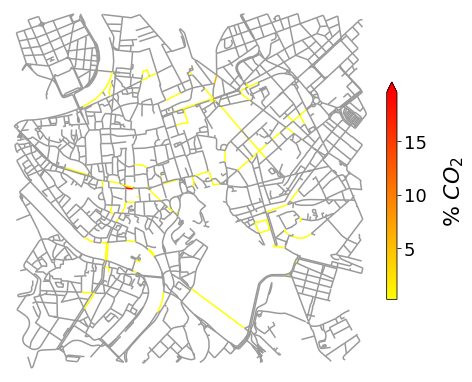

In [20]:
from mobair import plot
place = 'Rome (city center)'
fig, ax = plot.plot_road_network_with_attribute(road_network, 'CO_2', tdf_with_emissions=tdf_with_emissions, 
                                                region_name=place, normalization_factor='tot_emissions',
                                                fig_size = (8,8), n_bins=4, equal_size=True, 
                                                color_map='autumn_r', save_fig=False)

### Elevations and streets grades

In [21]:
from keys import airmap_api_key  # change with your own api key
ox.utils.config(elevation_provider = 'airmap')  # can be either “google” or “airmap”

# add elevation to each of the nodes, using the airmap elevation API, then calculate edge grades
road_network_with_node_elev = ox.add_node_elevations(road_network, api_key=airmap_api_key)
road_network_with_elevs = ox.add_edge_grades(road_network_with_node_elev)

In [22]:
import numpy as np

place = 'Rome (city center)'
edge_grades = [data['grade_abs'] for u, v, k, data in road_network_with_elevs.edges(keys=True, data=True)]

avg_grade = np.mean(edge_grades)
print('Average street grade in {} is {:.1f}%'.format(place, avg_grade*100))

med_grade = np.median(edge_grades)
print('Median street grade in {} is {:.1f}%'.format(place, med_grade*100))

Average street grade in Rome (city center) is 5.9%
Median street grade in Rome (city center) is 3.8%


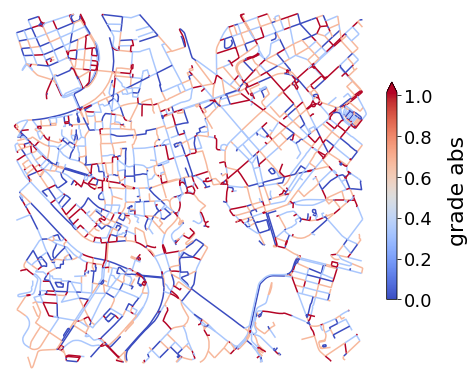

In [28]:
from mobair import plot

fig, ax = plot.plot_road_network_with_attribute(road_network_with_elevs, 'grade_abs', region_name=place,
                                                fig_size = (8,8), n_bins=4, equal_size=True,
                                                color_map='coolwarm', save_fig=False)

### Speed and travel time

In [41]:
## Note: the following is took from the osmnx examples of Gboeing (https://github.com/gboeing/osmnx-examples/blob/master/notebooks/02-routing-speed-time.ipynb)
# impute speed on all edges missing data
road_network_with_speeds = ox.add_edge_speeds(road_network_with_elevs)

# calculate travel time (seconds) for all edges
road_network_with_traveltimes = ox.add_edge_travel_times(road_network_with_speeds)

In [63]:
# see mean speed/time values by road type
edges = ox.graph_to_gdfs(road_network_with_traveltimes, nodes=False)
edges['highway'] = edges['highway'].astype(str)
edges.groupby('highway')[['length', 'speed_kph', 'travel_time']].mean().round(1)

,length,speed_kph,travel_time
highway,,,
"['living_street', 'residential']",92.3,50.0,6.6
"['service', 'residential']",120.6,31.4,15.2
"['service', 'tertiary']",125.8,32.5,13.9
"['unclassified', 'tertiary']",54.5,50.0,3.9
living_street,45.6,50.0,3.3
primary,105.0,48.7,7.9
primary_link,169.2,50.0,12.2
residential,65.6,34.0,7.0
secondary,70.5,48.8,5.3


In [64]:
print('Count of streets per type:')
edges['highway'].value_counts()

Count of streets per type:


residential                         1226
service                              694
tertiary                             396
secondary                            234
primary                               76
unclassified                          24
['service', 'residential']            14
living_street                          7
tertiary_link                          4
secondary_link                         2
['living_street', 'residential']       1
['service', 'tertiary']                1
primary_link                           1
['unclassified', 'tertiary']           1
Name: highway, dtype: int64

### Some statistics...

1. Correlation between the estimated emissions and (a) the radius of gyration, (b) the uncorrelated entropy of the trajectories in the `TrajDataFrame`.
2. Basic descriptive metric and topological stats for the road network.

In [24]:
## (1)
from mobair import stats

df_corr_coefs = stats.compute_corrs(tdf_with_emissions)

100%|██████████| 11/11 [00:00<00:00, 185.30it/s]

Computing radius of gyration...
Computing uncorrelated entropy...


Pearson's correlation coeffs:

                             CO_2                   NO_x  \
r_gyr       [0.40158102885789243]  [0.39768463033338025]   
un_entropy   [0.3847553347985236]   [0.3818459360724208]   

                              PM                    VOC  
r_gyr       [0.6499624520156648]  [0.39520433271143673]  
un_entropy  [0.5632736200494216]   [0.3799994180294881]  


In [27]:
## (2)

dict_network_stats = stats.compute_stats_for_network(road_network_with_elevs)
for key, val in dict_network_stats.items():
    print('%s : %s' %(key, val))

n : 1865
m : 3432
k_avg : 3.6804289544235926
intersection_count : 1628
streets_per_node_avg : 2.932439678284182
streets_per_node_counts : {0: 0, 1: 237, 2: 52, 3: 1207, 4: 341, 5: 25, 6: 3}
streets_per_node_proportion : {0: 0.0, 1: 0.12707774798927615, 2: 0.027882037533512063, 3: 0.6471849865951743, 4: 0.18284182305630026, 5: 0.013404825737265416, 6: 0.0016085790884718498}
edge_length_total : 216385.18600000034
edge_length_avg : 63.04929662004672
street_length_total : 172586.2990000001
street_length_avg : 64.37385266691537
street_segments_count : 2681
node_density_km : None
intersection_density_km : None
edge_density_km : None
street_density_km : None
circuity_avg : 1.062189855580145
self_loop_proportion : 0.003787878787878788
clean_intersection_count : None
clean_intersection_density_km : None


In [60]:
from mobair import utils

c_pollutant = 'CO_2'

list_roads_in_tdf = list(tdf_with_emissions['road_link'])
dict_road_to_length = utils.map_road_to_attribute(list_roads_in_tdf, road_network, 
                                                  attribute_name='length', default_value=np.nan)
dict_road_to_grade = utils.map_road_to_attribute(list_roads_in_tdf, road_network_with_elevs, 
                                                  attribute_name='grade_abs', default_value=np.nan)
dict_road_to_emissions = emissions.map_road_to_emissions(tdf_with_emissions, road_network, name_of_pollutant=c_pollutant)
dict_road_to_cumulate_emissions = {road: sum(em) for road, em in dict_road_to_emissions.items()}

set_roads = set(dict_road_to_cumulate_emissions.keys()) | set(dict_road_to_length.keys())
list_ordered_lengths = [dict_road_to_length.get(x, 0) for x in set_roads]
list_ordered_grades = [dict_road_to_grade.get(x, np.nan) for x in set_roads]
list_ordered_emissions = [dict_road_to_cumulate_emissions.get(x, 0) for x in set_roads]


road_length_total = np.nansum(list_ordered_lengths)
print('The vehicles included in the tdf covered %.2f meters of roads in the network.' %road_length_total)
print('')
avg_length = np.nanmean(list_ordered_lengths)
med_length = np.nanmedian(list_ordered_lengths)
avg_grade = np.nanmean(list_ordered_grades)
med_grade = np.nanmedian(list_ordered_grades)
print('The set of roads covered by the vehicles have:')
print('- average length of %.2f m (median %.2f m);' %(avg_length, med_length))
print('- average grade of %.1f%% (median %.1f%%).' %(avg_grade*100, med_grade*100))
print('')
corr_length = np.corrcoef(list_ordered_emissions, list_ordered_lengths)[0,1]
print('The Pearson correlation between emissions of %s on the roads and the length of each road is %.3f.' %(c_pollutant, corr_length))
corr_grade = np.corrcoef(list_ordered_emissions, list_ordered_grades)[0,1]
print('The Pearson correlation between emissions of %s on the roads and the grade of each road is %.3f.' %(c_pollutant, corr_grade))

The vehicles included in the tdf covered 9040.32 meters of roads in the network.

The set of roads covered by the vehicles have:
- average length of 97.21 m (median 75.06 m);
- average grade of 6.1% (median 5.3%).

The Pearson correlation between emissions of CO_2 on the roads and the length of each road is -0.055.
The Pearson correlation between emissions of CO_2 on the roads and the grade of each road is 0.036.
